# MultiUniMulitplication

A unit is a Strassen-Multiplication StepFunction.
Matrix multiplication to be performed is `m.dot(m.transpose)` with `m.dim(4000,4000)`.
M will be divided into `4*4=16` matrix partitions of dimension `1000*1000`. Partitions will be named m_row_col from m_0_0, m_0_1 ... to m_3_3.


m_0_0  |  m_0_1  |  m_0_2  |  m_0_3

m_1_0  |  m_1_1  |  m_1_2  |  m_1_3

m_2_0  |  m_2_1  |  m_2_2  |  m_2_3

m_3_0  |  m_3_1  |  m_3_2  |  m_3_3

## Content

1. Matrix Creation (matrix_dimension, block_sizes)
2. Matrix deployment (bucket, matrix_names)
3. Matrix multiplication (invoke matrix-multiplication-lambda)
4. check results in S3
5. create time profile for 3 stages (interm., collection, accumulation)
6. Compare Timings

matrix dimensions: 4000x4000, 8000x8000, 2000x16000   
block sizes: 1000x1000, 2000x2000, 3000x3000

## 0. Imports & Setup

In [2]:
from collections import namedtuple
from collections import defaultdict
from datetime import datetime
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
import os
import boto3
import json
import base64
import csv

In [90]:
# automatically reload the libraries from time_profiling.py
import sys
module_path = os.path.abspath(os.path.join('/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/benchmarks'))
if module_path not in sys.path:
    sys.path.append(module_path)
from time_profiling import *
%reload_ext autoreload
%autoreload 2

In [4]:
# NAMEDTUPLES
MatrixDimensions = namedtuple('MatrixDimensions', ['height', 'width'])
Timings = namedtuple('Timings', ['down','up','calculation'])

In [5]:
# global constants
BLOCK_SIZE = 1000
BUCKET = 'jmue-multiplication-benchmarks'
PREFIX = 'sq'
BENCHMARKS_FOLDER = '/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/benchmarks/'
SFN_PREFIX = 'log-test'

In [5]:
# CLIENTS
s3_client = boto3.client('s3')
lambda_client = boto3.client('lambda')
sfn_client = boto3.client('stepfunctions')

In [7]:
def _log(message):
    timestamp = datetime.now().strftime('%d.%m.%y %H:%M:%S > ')
#     LOG_FILE.write(timestamp + message)
    print timestamp + message

## 1. Matrix Creation

### Generate Matrix Blocks

### create random blocks

In [ ]:
def write_block_to_file(block, directory, row, column):
    
def get_block_with_random(height, width):

def create_blocks_with_random(x, y, block_height, block_width, matrix_name):

In [ ]:
create_blocks_with_random(
    matrix_dimensions.height/1000,
    matrix_dimensions.width/1000,
    block_size, block_size, matrix_name)

In [ ]:
create_blocks_with_random(
    matrix_dimensions.height/1000,
    matrix_dimensions.width/1000,
    block_size, block_size, matrix_name=matrix_name + "-2")

In [18]:
write_block_to_file(get_block_with_random(8000, 8000), '/Volumes/data/', 0, 0)

[WARNING] No LOG_FILE not defined. -> Debug mode.
08.10.17 12:23:03 > Writing block to file: /Volumes/data/m_0_0


In [19]:
a = np.array([[3,1], [1,2]])
b = np.array([9,8])
c = np.array()
x = np.linalg.solve(a, b)
x

array([ 2.,  3.])

## 2. Matrix Deployment

In [ ]:
def deployed(matrix_name, bucket):

def deploy_matrix(matrix_name, bucket):

In [ ]:
deployed('sq_2kx2k-2', 'jmue-multiplication-benchmarks')

## 3. Matrix Multiplication

### Create Input

In [ ]:
def create_input(state_machine_name, executionName, name_matrixA, name_matrixB):

In [ ]:
create_input(
        state_machine_name="multi-unit-mmultiply-2kx2k",
        executionName="2kx2k-online-profiled-3",
        name_matrixA=matrix_name,
        name_matrixB=matrix_name + "-2"
)

### Invoke Matrix Multiplication Lambda

In [ ]:
def invoke_matrix_multiplication(state_machine_name, executionName, name_matrixA, name_matrixB):

In [ ]:
payload = invoke_matrix_multiplication(
        state_machine_name="multi-unit-mmultiply-2kx2k",
        executionName="2kx2k-online-profiled-3",
        name_matrixA=matrix_name,
        name_matrixB=matrix_name + "-2"
)

In [778]:
payload

{u'deploy-nr': u'MUM101',
 u'split-executions': [{u'executionARN': u'arn:aws:states:eu-central-1:146904559692:execution:multi-unit-mmultiply-2kx2k:2kx2k-online-profiled-3-split0',
   u'split': 0}],
 u'state-machine-arn': u'arn:aws:states:eu-central-1:146904559692:stateMachine:multi-unit-mmultiply-2kx2k'}

## 5. Check Results

In [ ]:
def executions_pending(executionARNs):
    """ Checks if all executions have either succeeded or failed yet.
    Failed executions are skipped. """


In [ ]:
executionARN = payload['split-executions'][0]['executionARN']

## 6. Create Timing Profiles

### Get all Timings

In [ ]:
def extract_time_profiles(events):
    """ Time profiles are part of the lambda output which is returned as a json formated string """
    
def get_all_events(executionARNs):

def parse_time_profiles(executionARNs):

In [109]:
example_time_profiles_by_lambda ={
             u'accumulate': [{u'execution': 463,
               u'lambda': u'accumulate',
               u's3-down': 181,
               u's3-up': 272}],
             u'collect': [{u'execution': 2978,
               u'lambda': u'collect',
               u's3-down': 1741,
               u's3-up': 1166}],
             u'intermediate': [{u'execution': 2303,
               u'lambda': u'intermediate',
               u's3-down': 923,
               u's3-up': 189},
              {u'execution': 2693,
               u'lambda': u'intermediate',
               u's3-down': 980,
               u's3-up': 518},
              {u'execution': 2152,
               u'lambda': u'intermediate',
               u's3-down': 735,
               u's3-up': 247},
              {u'execution': 2295,
               u'lambda': u'intermediate',
               u's3-down': 902,
               u's3-up': 261},
              {u'execution': 2288,
               u'lambda': u'intermediate',
               u's3-down': 868,
               u's3-up': 242},
              {u'execution': 2489,
               u'lambda': u'intermediate',
               u's3-down': 993,
               u's3-up': 347},
              {u'execution': 2416,
               u'lambda': u'intermediate',
               u's3-down': 1000,
               u's3-up': 299}]}

## Plot Results

In [ ]:
def generate_plot(timings, lambda_type, state_machine_name, plot_folder, save_to_file=True):

def collect_values(time_profiles_by_lambda, add_average=True):
    """collect values into arrays and return them as a timings tuple"""

def plot_time_profiles(time_profiles_by_lambda, state_machine_name, folder):

### Intermediate Timings

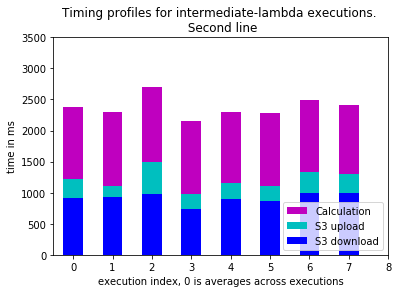

In [707]:
lambda_type = 'intermediate'
intermediate_timings = collect_values(time_profiles_by_lambda[lambda_type], add_average=True)
generate_plot(intermediate_timings, lambda_type, to_file=False)

### Collector Timings

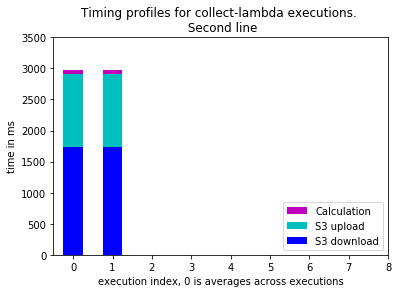

In [676]:
lambda_type = 'collect'
collect_timings = collect_values(time_profiles_by_lambda[lambda_type], add_average=True)
generate_plot(collect_timings, lambda_type, to_file=False)

### Accumulator Timings

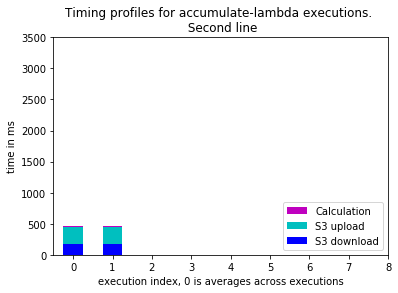

In [674]:
lambda_type = 'accumulate'
generate_plot(timings, 'all lambda', to_file=False)

### Combined Timings from file

In [61]:
# Load timings from csv
folder = '/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/benchmarks/v3_benchmark_bs2/block_size_2000/'
filename = 'v3_benchmark_bs2-8kx8k.csv'

path = os.path.join(folder, filename)

combined_timings = Timings(np.array(up, dtype=int), np.array(down, dtype=int), np.array(calculation, dtype=int))

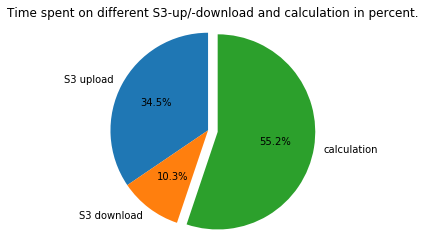

In [92]:
plot_time_distribution(combined_timings, None, to_file=False)

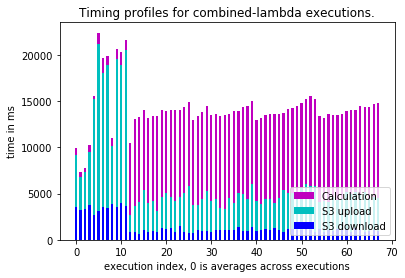

In [93]:
plot_timing_profile(combined_timings, "combined", "v3_benchmark_bs2-8kx8k", "plot-folder", save_to_file=False)

In [42]:
def plot_time_distribution(up, down, calculation):
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:

In [52]:
# bs1000 - 4000k

In [ ]:
plot_time_distribution(np.average(combined_timings.up), np.average(combined_timings.down), np.average(combined_timings.calculation))

In [101]:
data = np.array([1,2,3])
s3_client.put_object(Body=data.dumps(), Bucket='jmue-matrix-tests', Key='put-object')

{u'ETag': '"c2fd187af5f8937bf52ad74880ae3e09"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Fri, 22 Sep 2017 15:22:14 GMT',
   'etag': '"c2fd187af5f8937bf52ad74880ae3e09"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'xC1KupFOijlB/Br/2Z5GF36R/ftfxvlUWxkU4KGIYP3822fmn/ia8es7D5hC2T1rQkd4/0hUycs=',
   'x-amz-request-id': '49593830053D54FF'},
  'HTTPStatusCode': 200,
  'HostId': 'xC1KupFOijlB/Br/2Z5GF36R/ftfxvlUWxkU4KGIYP3822fmn/ia8es7D5hC2T1rQkd4/0hUycs=',
  'RequestId': '49593830053D54FF',
  'RetryAttempts': 0}}

In [102]:
s3_client.download_file('jmue-matrix-tests', 'put-object', '/tmp/put-object')
np.load('/tmp/put-object')

array([1, 2, 3])

## Save raw data to file

In [801]:
def save_raw_data(time_profiles_by_lambda, csv_path):

In [33]:
time_profiles_by_lambda

NameError: name 'time_profiles_by_lambda' is not defined

### Create Plots

In [87]:
%reload_ext autoreload

In [94]:
def find_ybound(csv_path):
    timings = load_timings(csv_path)
    execution_times = map(lambda t: t.execution, timings)
    return max(excution_times)

In [102]:
load_timings(csv_path, lambda_type='intermediate')

Timings(down=array([ 896,  840,  938, 1005,  881,  964,  894]), up=array([2128, 2495, 2598, 2449, 2347, 3009, 2832]), calculation=array([7885, 8983, 9293, 9270, 9463, 9328, 9243]))

In [98]:
print timings
print timings.down + timings.up + timings.calculation

Timings(down=array([2632, 3557,  896,  840,  938, 1005,  881,  964,  894]), up=array([1810, 3923, 2128, 2495, 2598, 2449, 2347, 3009, 2832]), calculation=array([ 250,  825, 7885, 8983, 9293, 9270, 9463, 9328, 9243]))
[ 4692  8305 10909 12318 12829 12724 12691 13301 12969]


In [73]:
csv_path = '/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/benchmarks/v4_benchmark/block_size_2000/v4_benchmark-4kx4k.csv'
intermediate_timings = load_timings(csv_path, 'accumulate')
print intermediate_timings
intermediate_timings_with_avg = append_average(intermediate_timings)
print intermediate_timings_with_avg

Timings(down=array([2632]), up=array([1810]), calculation=array([250]))
Timings(down=array([ 2632.,  2632.]), up=array([ 1810.,  1810.]), calculation=array([ 250.,  250.]))


[WARNING] No LOG_FILE not defined. -> Debug mode.
13.10.17 01:28:41 > Creating plot made-up-name lambda_type


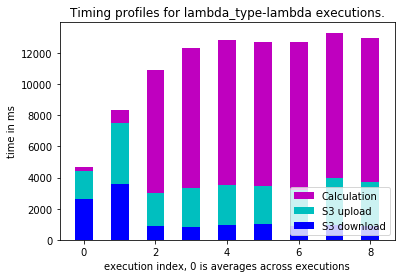

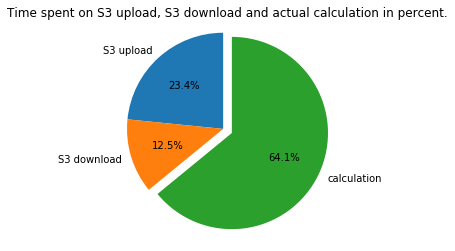

In [43]:
create_combined_plots(csv_path, 'made-up-name', to_file=False)

[WARNING] No LOG_FILE not defined. -> Debug mode.
13.10.17 02:31:47 > Creating plot masfn intermediate


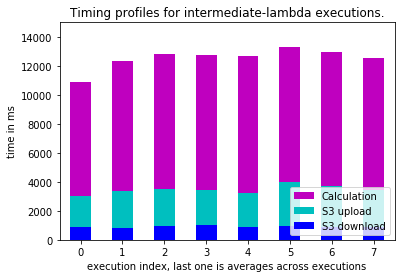

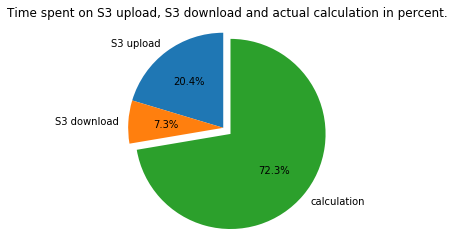

[WARNING] No LOG_FILE not defined. -> Debug mode.
13.10.17 02:31:48 > Creating plot masfn collect


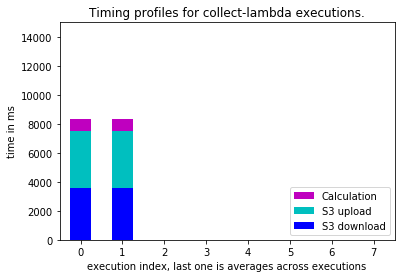

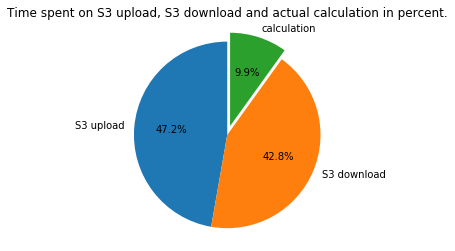

[WARNING] No LOG_FILE not defined. -> Debug mode.
13.10.17 02:31:48 > Creating plot masfn accumulate


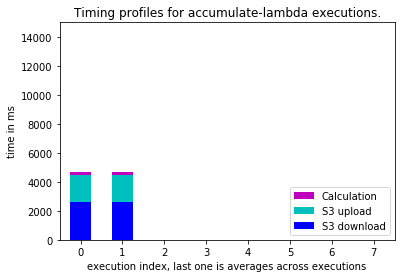

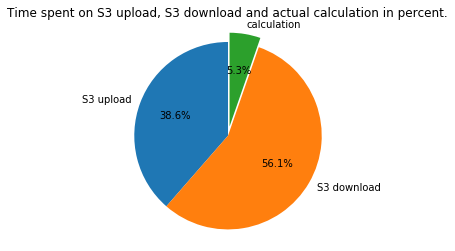

In [86]:
create_plots_per_lambda(csv_path, 'masfn', to_file=False)

In [179]:
collect_timings = load_timings('/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/benchmarks/v4_8k_bs4k/block_size_4000/v4_8k_bs4k-8kx8k.csv', 'collect')

In [188]:
m = {3: 4}

In [190]:
m.has_key(4)

False

In [191]:
%%time
np.load('/Volumes/data/sq_8kx8k_bs4k/m_0_0.npy')

CPU times: user 1.59 ms, sys: 145 ms, total: 147 ms
Wall time: 893 ms


array([[ 0.2301815 ,  0.98993007,  0.69207587, ...,  0.28137766,
         0.92584622,  0.09365729],
       [ 0.65460598,  0.54159854,  0.94925243, ...,  0.58498415,
         0.55808368,  0.00550115],
       [ 0.52902089,  0.55998729,  0.56323363, ...,  0.75962579,
         0.58405592,  0.92357941],
       ..., 
       [ 0.17928147,  0.53412024,  0.41630925, ...,  0.60843013,
         0.58038935,  0.46143703],
       [ 0.24877506,  0.6926001 ,  0.59344857, ...,  0.23063171,
         0.29694194,  0.43964992],
       [ 0.74517637,  0.52624862,  0.38861089, ...,  0.50856937,
         0.3219063 ,  0.44976188]])

## Print Metadata

number of elements, number of intermediate-, collect-, accumulate-lambdas ...

In [122]:
events = get_all_events(['arn:aws:states:eu-central-1:146904559692:execution:v4_benchmark_3-6kx6k:v4_benchmark_3-6kx6k-split0'])
failed_exec_events = get_all_events(['arn:aws:states:eu-central-1:146904559692:execution:v4_benchmark_10_bs4k-10kx10k:v4_benchmark_10_bs4k-10kx10k-split0'])
save_sfn_metadata(events, '/tmp/meta.csv')
save_sfn_metadata(failed_exec_events, '/tmp/meta.csv')

[WARNING] No LOG_FILE not defined. -> Debug mode.
15.10.17 21:10:45 > Retrieving execution history for arn:aws:states:eu-central-1:146904559692:execution:v4_benchmark_3-6kx6k:v4_benchmark_3-6kx6k-split0


In [139]:
last_event = events[len(events)-1]
last_event.keys()[0]

2017-10-14 17:18:05.404000+02:00
2017-10-14 17:16:39.449000+02:00


[u'executionSucceededEventDetails',
 u'timestamp',
 u'type',
 u'id',
 u'previousEventId']

## EXECUTE BENCHMARK

### Input Format

In [ ]:
{
  "matA": {
    "bucket": "jmue-matrix-tests",
    "key": "sc4000",
    "split": { ... }
  },
  "matB": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000t",
      "split": { ... }
  },
  "result": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000-result"
  }
}

{
  "matA": {
    "bucket": "jmue-matrix-tests",
    "key": "sc4000",
    "split": {
      "x1": 0,
      "y1": 0,
      "x2":1000,
      "y2":1000
    }
  },
  "matB": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000t",
      "split": {
        "x1": 0,
        "y1": 0,
        "x2":1000,
        "y2":1000
      }
  },
  "result": {
      "bucket": "jmue-matrix-tests",
      "key": "sc4000-result"
  }
}

# A split
{
  "split": {
    "x1": 0,
    "y1": 0,
    "x2":1000,
    "y2":1000
  }
}

In [175]:
matrix = { "bucket": "jmue-matrix-tests", "key": "sc4000", "split": { "x1": 0, "y1": 0, "x2":1000, "y2":1000 } }
x1 = matrix['split']['x1']
y1 = matrix['split']['y1']
key = matrix['key'] +  "/m_" + str(x1) + "_" + str(y1) + ".npy"
print key

sc4000/m_0_0.npy


In [184]:
if not False:
    print "False"

False


In [185]:
if not os.path.exists('/tmp/' + matrix['key']):
    os.mkdir('/tmp/' + matrix['key'])
s3_client.download_file('jmue-matrix-tests', key, '/tmp/' + key)
split = np.load('/tmp/' + key)

In [174]:
split

array([[   0,    1,    2, ...,  997,  998,  999],
       [   1,    2,    3, ...,  998,  999, 1000],
       [   2,    3,    4, ...,  999, 1000, 1001],
       ..., 
       [ 997,  998,  999, ..., 1994, 1995, 1996],
       [ 998,  999, 1000, ..., 1995, 1996, 1997],
       [ 999, 1000, 1001, ..., 1996, 1997, 1998]])

In [5]:
import json
import math

In [83]:
b = 5
a = {"key": b, "key2": "Hello"}
sfn_input = json.dumps({"value": a["key"]})

In [84]:
sfn_input

'{"value": 5}'

In [98]:
int(math.ceil(4030.0/2000.0))

3

In [150]:
ssl = 1000
def call_multi(i,j,k):
    print "x1", str(i*ssl), "y1", str(k*ssl), "| x1", str(k*ssl), "y1", str(j*ssl)
    print "x2", str((i+1)*ssl), "y2", str((k+1)*ssl), "| x2", str((k+1)*ssl), "y2", str((j+1)*ssl)

In [151]:
m = 3
n = 2
p = 2

for i in range(m):
    for j in range(n):
        for k in range(p):
            print "A" + str(i+1) + str(k+1) + "*" + "B" + str(k+1) + str(j+1)
            call_multi(i,j,k)
        print ""

A11*B11
x1 0 y1 0 | x1 0 y1 0
x2 1000 y2 1000 | x2 1000 y2 1000
A12*B21
x1 0 y1 1000 | x1 1000 y1 0
x2 1000 y2 2000 | x2 2000 y2 1000

A11*B12
x1 0 y1 0 | x1 0 y1 1000
x2 1000 y2 1000 | x2 1000 y2 2000
A12*B22
x1 0 y1 1000 | x1 1000 y1 1000
x2 1000 y2 2000 | x2 2000 y2 2000

A21*B11
x1 1000 y1 0 | x1 0 y1 0
x2 2000 y2 1000 | x2 1000 y2 1000
A22*B21
x1 1000 y1 1000 | x1 1000 y1 0
x2 2000 y2 2000 | x2 2000 y2 1000

A21*B12
x1 1000 y1 0 | x1 0 y1 1000
x2 2000 y2 1000 | x2 1000 y2 2000
A22*B22
x1 1000 y1 1000 | x1 1000 y1 1000
x2 2000 y2 2000 | x2 2000 y2 2000

A31*B11
x1 2000 y1 0 | x1 0 y1 0
x2 3000 y2 1000 | x2 1000 y2 1000
A32*B21
x1 2000 y1 1000 | x1 1000 y1 0
x2 3000 y2 2000 | x2 2000 y2 1000

A31*B12
x1 2000 y1 0 | x1 0 y1 1000
x2 3000 y2 1000 | x2 1000 y2 2000
A32*B22
x1 2000 y1 1000 | x1 1000 y1 1000
x2 3000 y2 2000 | x2 2000 y2 2000



In [242]:
def partition(matrix, x, y):
    split = matrix['split']
    x += split['x1']/1000
    y += split['y1']/1000
    partition_factor = ((split['x2']-split['x1'])/2)/1000 # length of split us twice the size of a partition

    filename = "m_" + str(partition_factor*x) + "_" + str(partition_factor*y) + ".npy"
    key = matrix['folder'] + "/" + filename # e.g. m_0_0.npy

    if not os.path.exists('/tmp/' + matrix['folder']):
        os.mkdir('/tmp/' + matrix['folder'])

    print key
    s3_client.download_file(matrix['bucket'], key, '/tmp/' + key)
    return np.load('/tmp/' + key)

In [241]:
s3_client.download_file("jmue-matrix-tests", "sc4000/m_3_2.npy", '/tmp/sc4000/m_3_2.npy')

In [244]:
matrix = { "bucket": "jmue-matrix-tests", "folder": "sc4000", "split": { "x1": 2000, "y1": 2000, "x2":4000, "y2":4000 } }
partition(matrix=matrix, x=1, y=0)

sc4000/m_3_2.npy


array([[5000, 5001, 5002, ..., 5997, 5998, 5999],
       [5001, 5002, 5003, ..., 5998, 5999, 6000],
       [5002, 5003, 5004, ..., 5999, 6000, 6001],
       ..., 
       [5997, 5998, 5999, ..., 6994, 6995, 6996],
       [5998, 5999, 6000, ..., 6995, 6996, 6997],
       [5999, 6000, 6001, ..., 6996, 6997, 6998]])

## Building a State Machine in Code

In [78]:
def task_state(resource, next_state=None):
    task_state = {
            "Type": "Task",
            "Resource": resource,
            "End": True
    }
    if next_state is not None:
        task_state["End"] = False
        task_state["Next"] = next_state
    return task_state

In [79]:
def pass_state(next_state, result=None, resultPath=None, outputPath=None):
    return {
              "Type": "Pass",
              "Result": result,
              "ResultPath": resultPath,
              "OutputPath": outputPath,
              "Next": next_state
    }

In [114]:
def parallel_state(branches, next_state, resultPath=None, outputPath=None):
    parallel_state = {
            "Type": "Parallel",
            "Next": next_state,
            "Branches": branches
    }
    if resultPath is not None:
        parallel_state["ResultPath"] = resultPath
    
    if outputPath is not None:
        parallel_state["OutputPath"] = outputPath
    
    return parallel_state

In [81]:
def branch(startAt, states):
    return {
        "StartAt": startAt,
        "States": states
    }

In [118]:
def create_strassen_sfn(unit=""):
    branches = []
    for index in range(0,7):
        unit_m = "U{}_m{}".format(unit, index) # U0_m_0
        unit_m_lambda = "U{}_m{}_lambda".format(unit, index) # U0_m_0_lambda
        states = {
            unit_m: pass_state(next_state=unit_m_lambda, result=index, resultPath="$.intermediate", outputPath="$"),
            unit_m_lambda: task_state(resource="arn:aws:lambda:eu-central-1:146904559692:function:mmultiply-prod-strassen-split-intermediate")
        }
        branches.append(branch(states=states, startAt=unit_m))

    unit_name = "unit" + unit
    i_name = "U{}_Intermediate".format(unit)
    c_name = "U{}_Collect".format(unit)
    
    unit_setup = pass_state(next_state=i_name, result=unit, resultPath="$.unit", outputPath="$")
    intermediates = parallel_state(branches=branches, next_state=c_name, resultPath="$.responses", outputPath="$")
    collect = task_state(resource="arn:aws:lambda:eu-central-1:146904559692:function:mmultiply-prod-strassen-split-collector")
        
    states = { unit_name: unit_setup, i_name: intermediates, c_name: collect }
    return branch(startAt=unit_name, states=states)

In [122]:
accumulation_arn="arn:aws:lambda:eu-central-1:146904559692:function:mmultiply-prod-unit-accumulator"
unit_branches = []
for i in range(0,2):
    unit_branches.append(create_strassen_sfn(unit=str(i)))

split_states = {
    "Accumulate": task_state(resource=accumulation_arn),
    "Units": parallel_state(branches=unit_branches, next_state="Accumulate", resultPath="$.responses", outputPath="$")
}
partial = branch(startAt="Units", states=split_states)

In [123]:
with open('/Users/Johannes/Uni/Master/Master Arbeit/repos/matrix-operations/state-machines/created.asl', 'w') as file:
    json.dump(partial, file)

In [124]:
result = { "folder": "sc4000-result"}
split = 3
block_index = "00"
response = s3_client.list_objects_v2(
      Bucket="jmue-matrix-tests",
      Prefix="{}/S{}_X{}".format(result['folder'], split, block_index)
    )

In [125]:
response

{u'Contents': [{u'ETag': '"675ba5b88cb01f66bd6b56d15646cc5e"',
   u'Key': 'sc4000-result/S3_X00_U0',
   u'LastModified': datetime.datetime(2017, 8, 4, 15, 59, 30, tzinfo=tzutc()),
   u'Size': 8000080,
   u'StorageClass': 'STANDARD'},
  {u'ETag': '"675ba5b88cb01f66bd6b56d15646cc5e"',
   u'Key': 'sc4000-result/S3_X00_U1',
   u'LastModified': datetime.datetime(2017, 8, 4, 15, 59, 25, tzinfo=tzutc()),
   u'Size': 8000080,
   u'StorageClass': 'STANDARD'}],
 u'IsTruncated': False,
 u'KeyCount': 2,
 u'MaxKeys': 1000,
 u'Name': 'jmue-matrix-tests',
 u'Prefix': 'sc4000-result/S3_X00',
 'ResponseMetadata': {'HTTPHeaders': {'content-type': 'application/xml',
   'date': 'Fri, 04 Aug 2017 16:19:37 GMT',
   'server': 'AmazonS3',
   'transfer-encoding': 'chunked',
   'x-amz-bucket-region': 'eu-central-1',
   'x-amz-id-2': 'e5IR4vIgZJX00HgHbBgBixJWhyqTlnZEKdV+bQatEGkGUysJGlAbJeewKRGgS4YVQvJ5IJth4g0=',
   'x-amz-request-id': '11F1494C37A87A8E'},
  'HTTPStatusCode': 200,
  'HostId': 'e5IR4vIgZJX00HgHbBg

### Padded matrix multiplication has the same result

In [5]:
import numpy as np
j = np.array([[x for x in range(10)],
              [x for x in range(10)],
              [x for x in range(10)],
              [x for x in range(10)],
              [x for x in range(10)]])
j_padded = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
i = j.transpose()
i_padded = j_padded.transpose()
np.array_equal(i_padded.dot(j_padded), i.dot(j))

True

1.21951219512e-06
9.375e-05


78.33333333333333